In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn_genetic import GAFeatureSelectionCV
import optuna

# Warning off
import warnings
warnings.filterwarnings('ignore')

# Cargar Dataset

In [75]:
import pandas as pd

filepath = "./ds_salaries.csv"
df = pd.read_csv(filepath)

df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


# Exploratory Data Analysis (EDA)

In [77]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


Revisamos que no hayan valores nulos en el dataset.

In [78]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

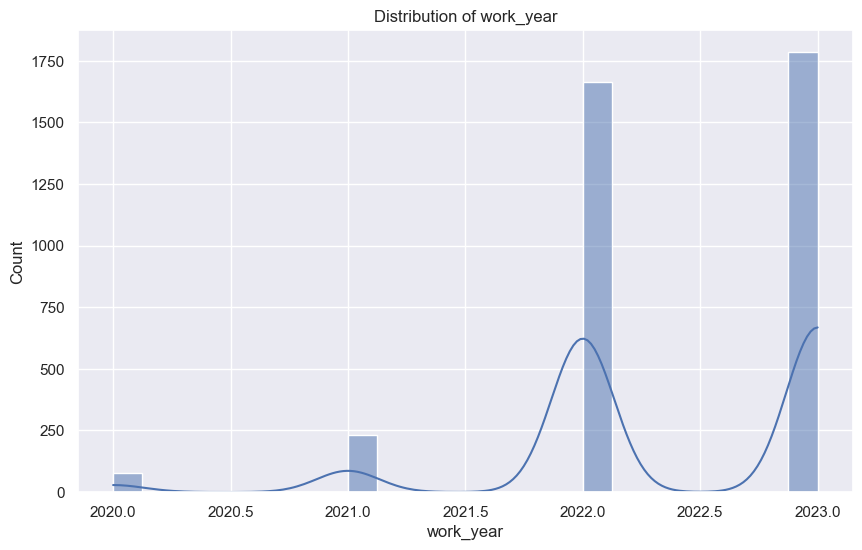

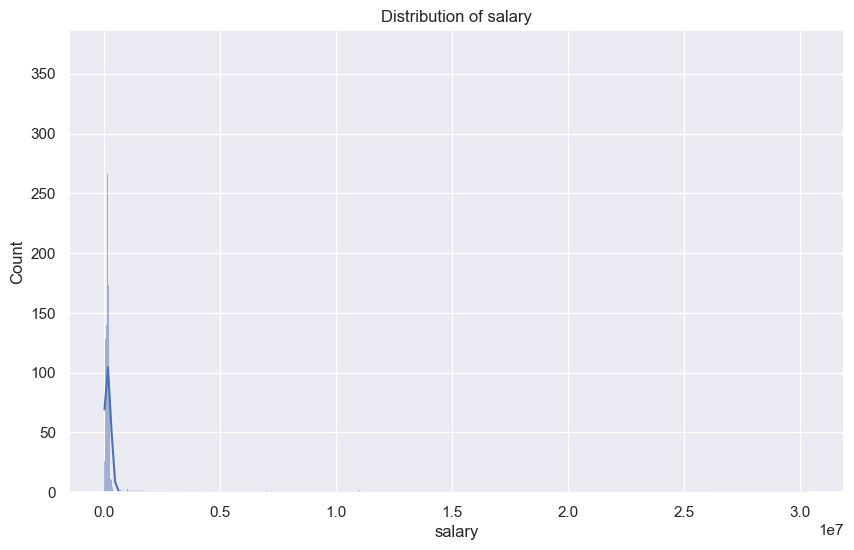

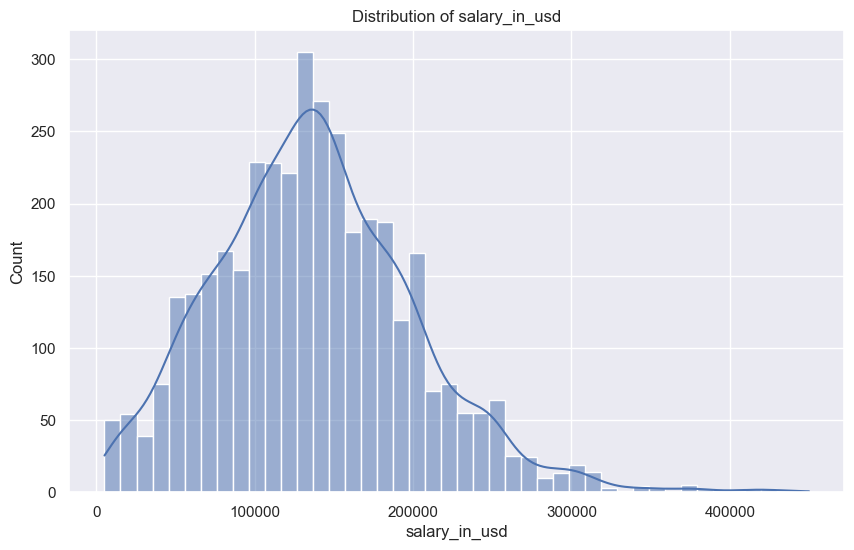

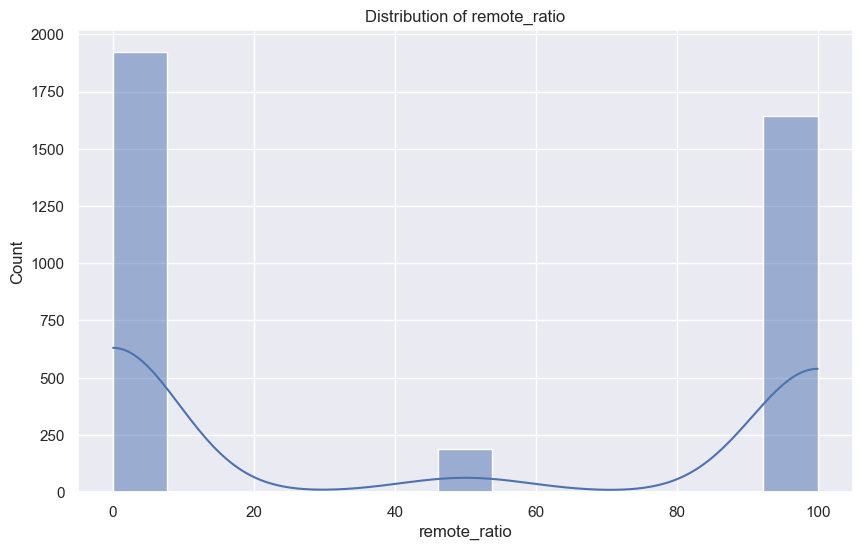

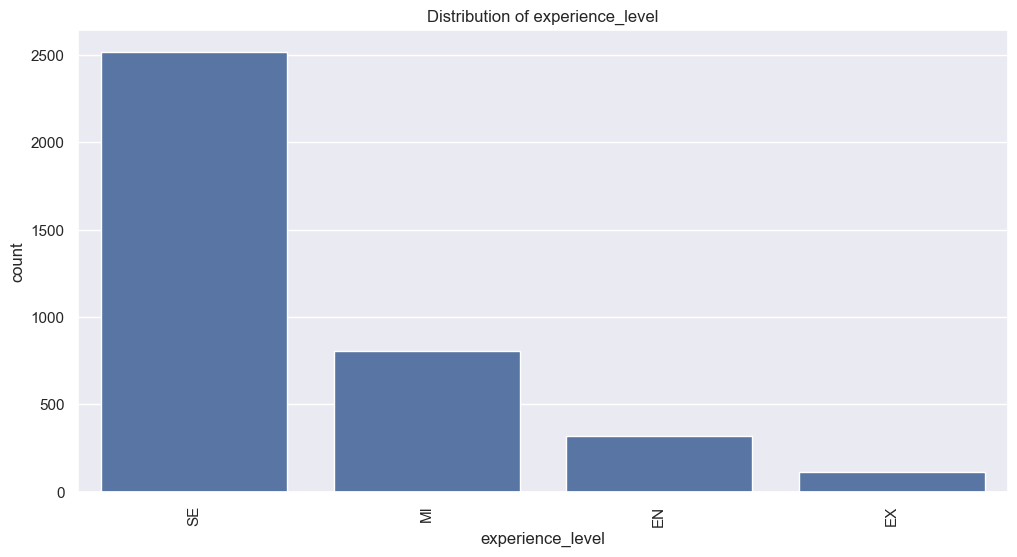

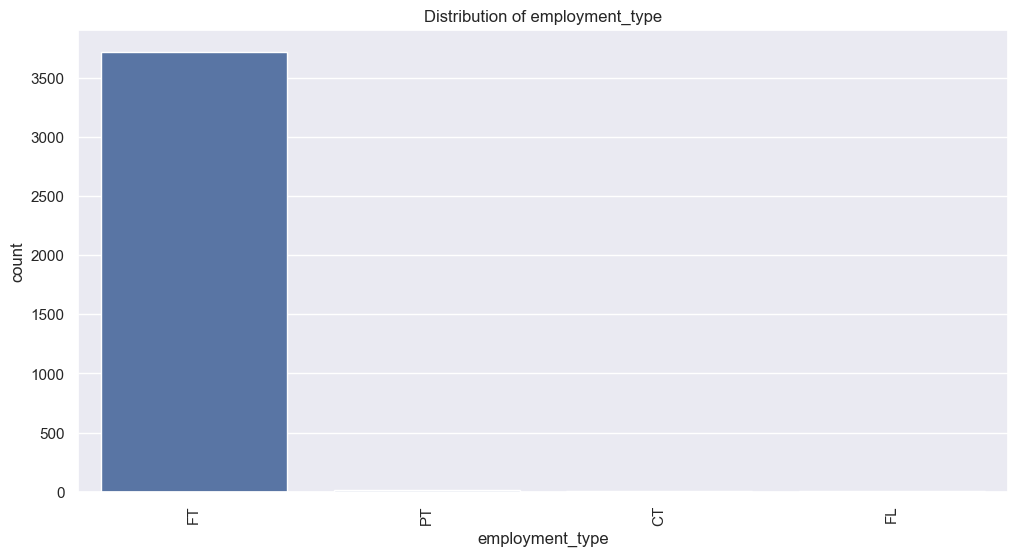

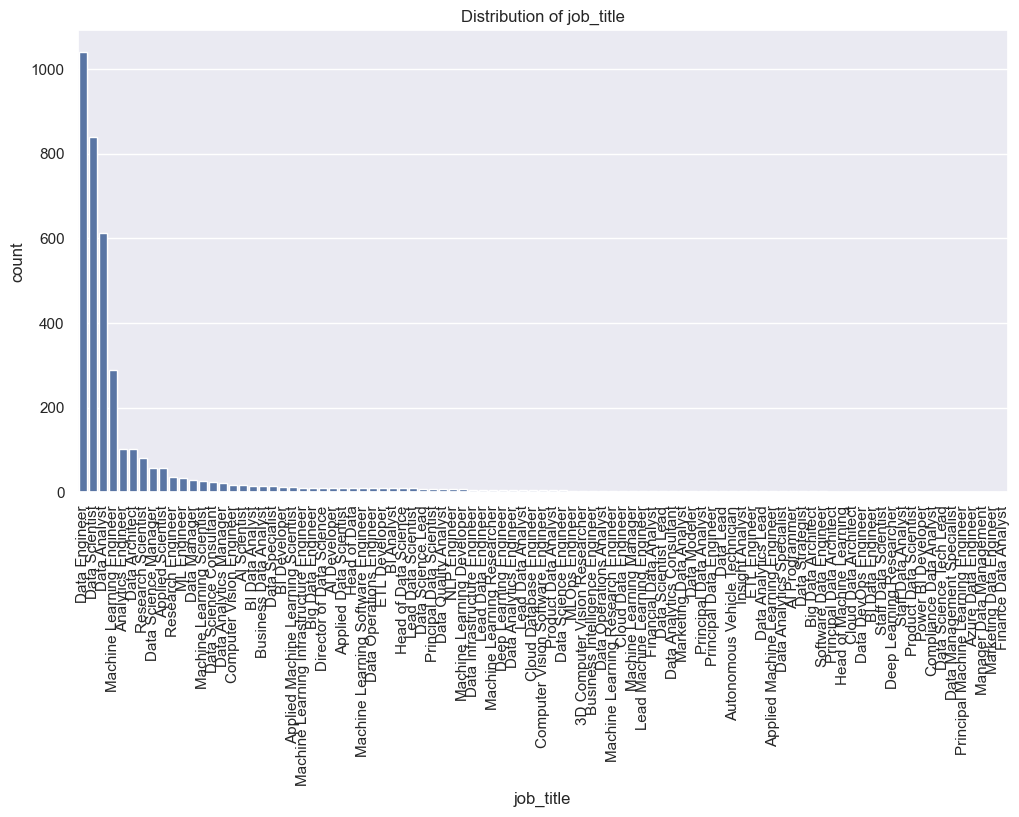

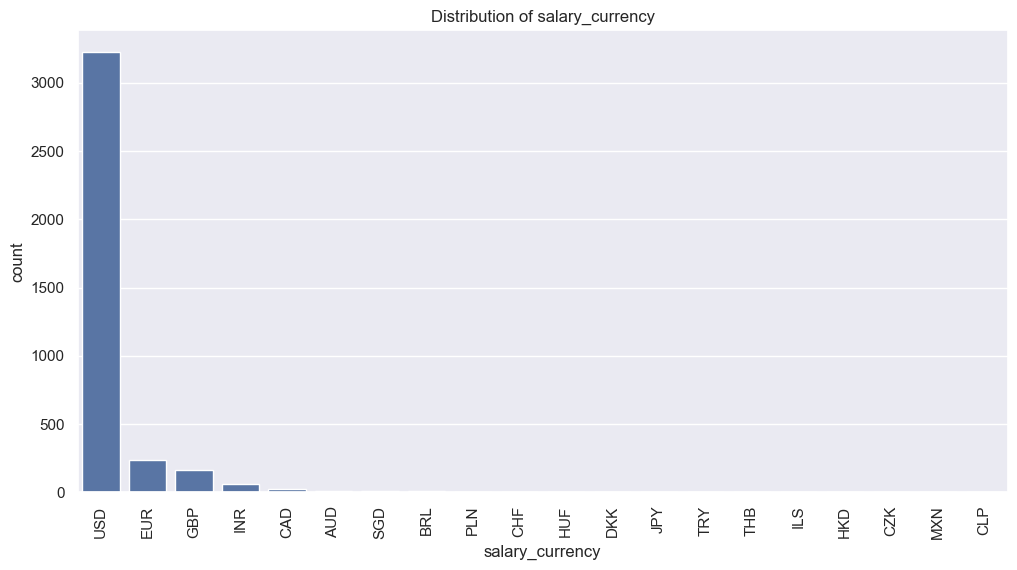

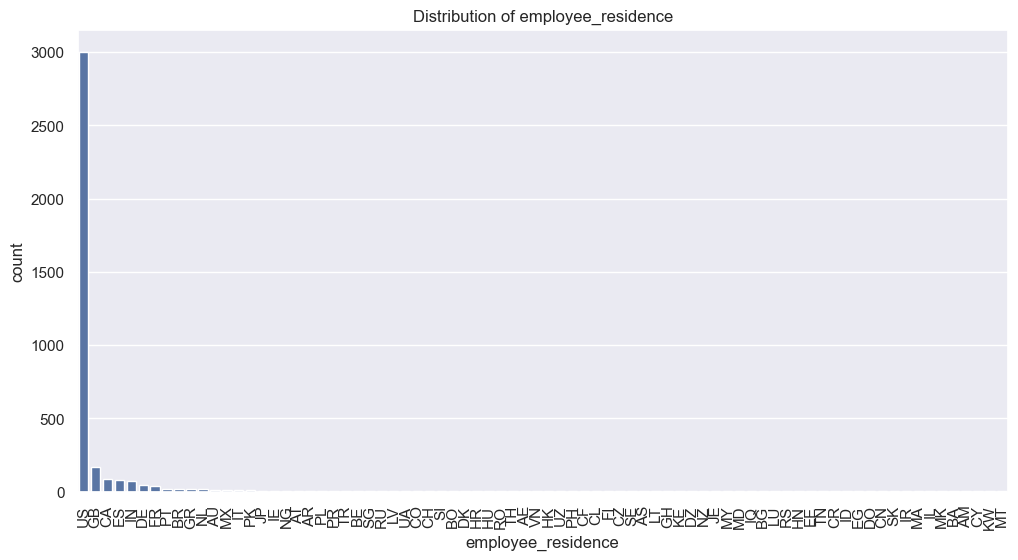

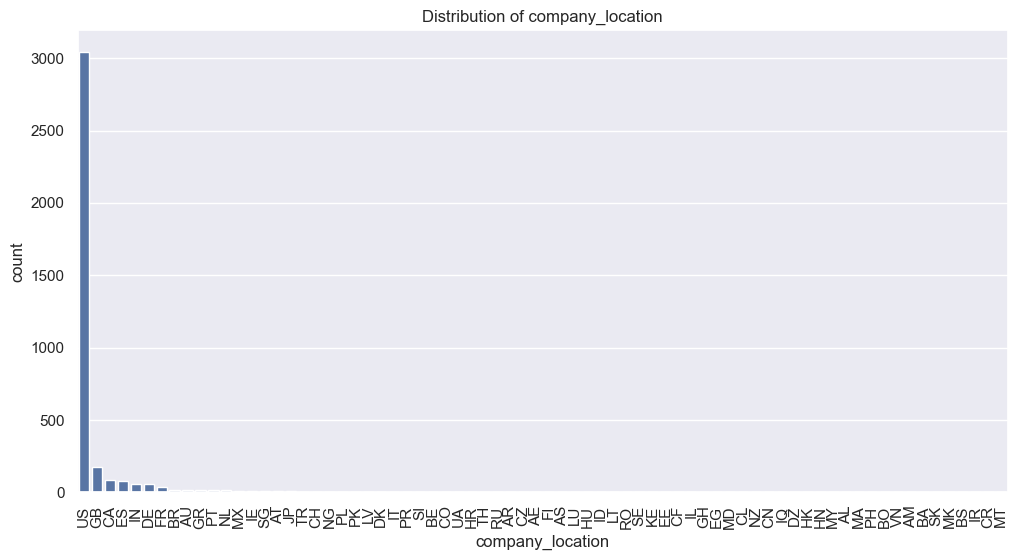

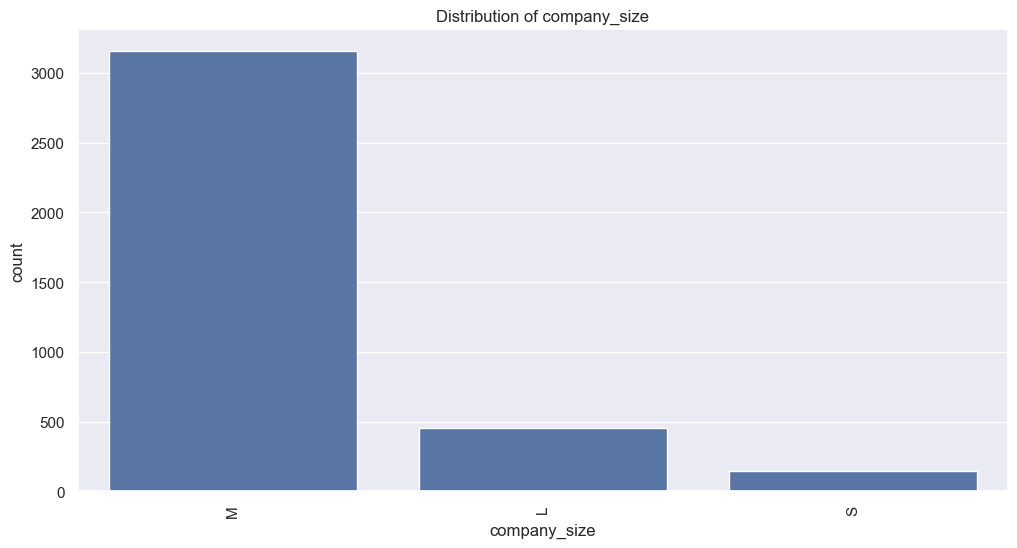

In [79]:
# Visualizar la distribucion de variables numericas
numerical_features = df.select_dtypes(include=[np.number]).columns
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Visualizar la distribucion de variables categoricas
categorical_features = df.select_dtypes(include=[object]).columns
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=90)
    plt.show()

Con base en los gráficos de distribución, se observa que las columnas `employment_type`, `salary_currency`, `employee_residence`, `company_location` y `company_size` presentan un valor predominante en comparación con los demás, lo que genera ruido para el modelo y aporta poca información relevante; por ello, se optará por eliminarlas. Asimismo, se eliminará la columna `salary`, ya que contiene muchos valores atípicos y una distribución compleja en comparación con `salary_in_usd`, que presenta una distribución más uniforme y adecuada.

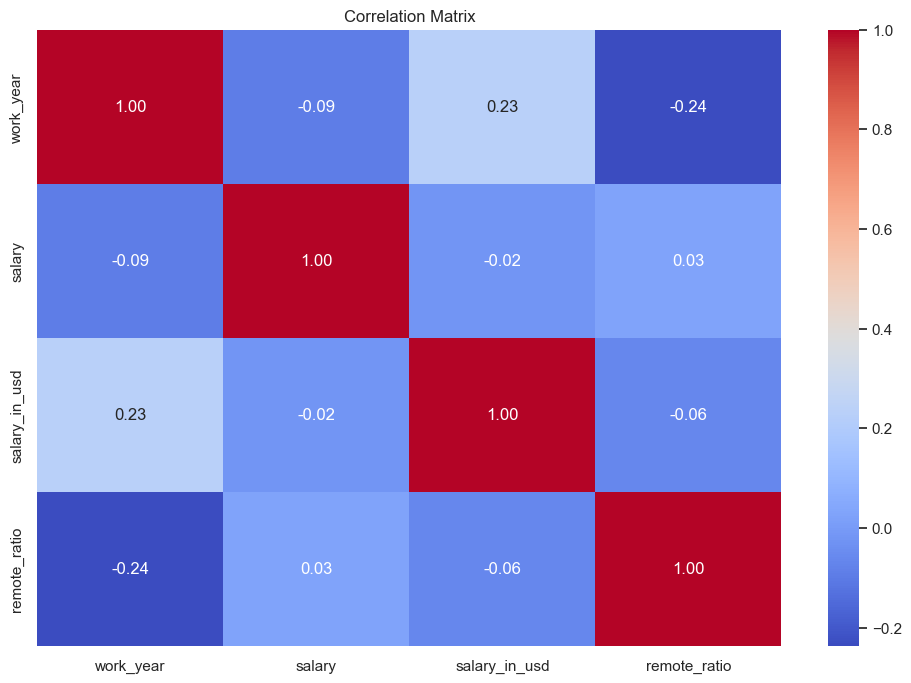

In [80]:
# Visualizar la matrix de correlacion
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

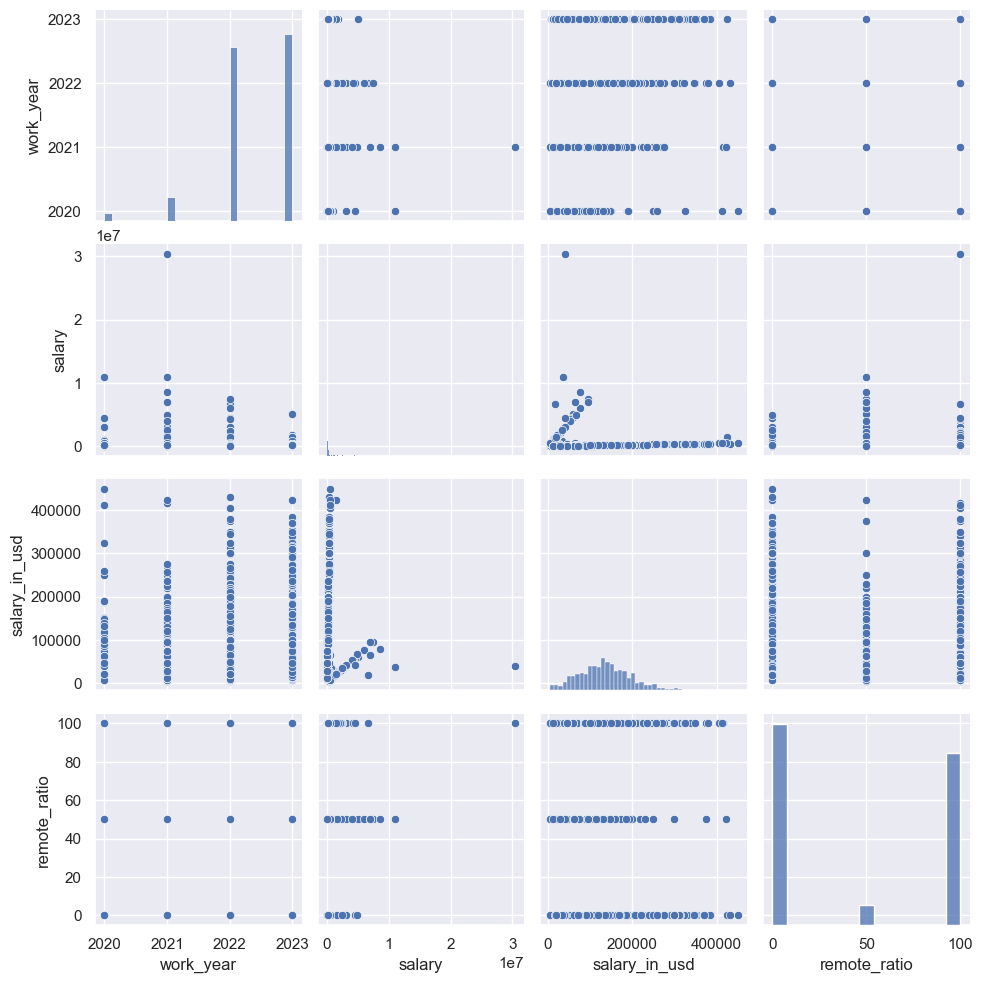

In [81]:
# Visualizar la relacion entre variables numericas
sns.pairplot(df[numerical_features])
plt.show()

# Preprocesamiento de los datos

In [82]:
df.drop(
    [
        "employment_type",
        "salary_currency",
        "employee_residence",
        "company_location",
        "salary",
        "company_size",
    ],
    axis=1,
    inplace=True,
)

Se eliminan estas columnas ya que no aportan y afectan de manera negativamente en el entrenamiento del modelo

## Procesamiento de la columna `job_title`

<Axes: xlabel='job_title'>

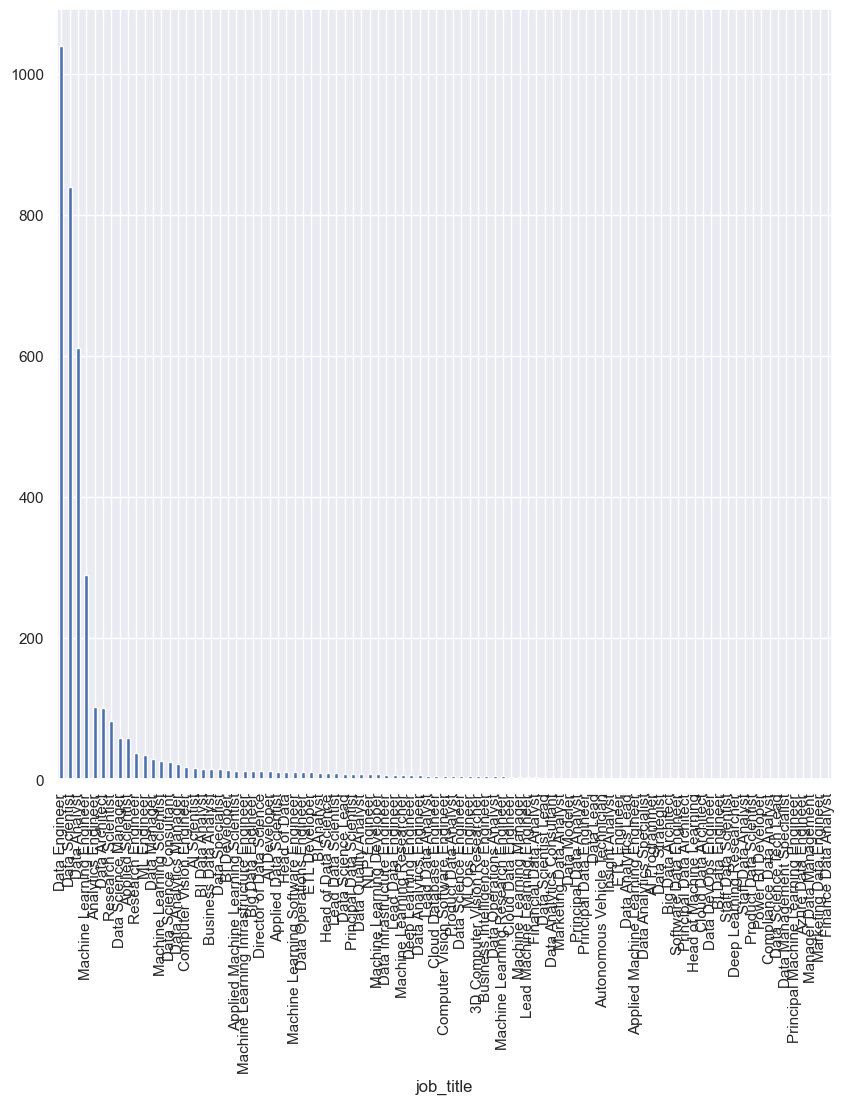

In [83]:
df.job_title.value_counts().plot(kind='bar')

<Axes: xlabel='job_title'>

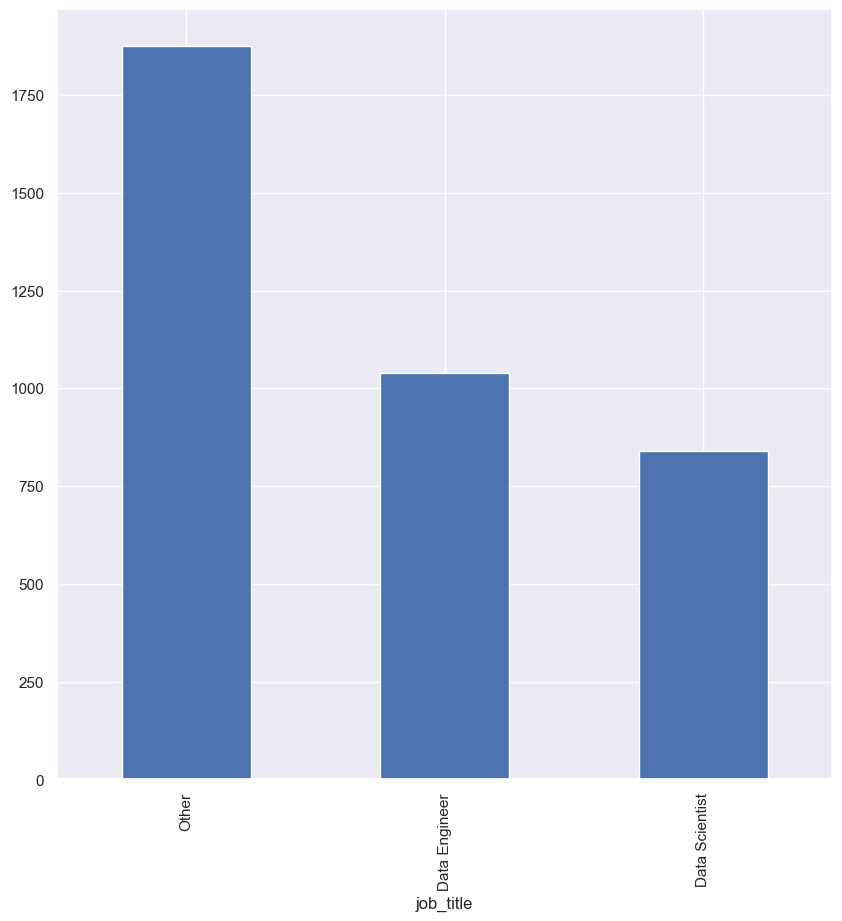

In [84]:
top_jobs = set(df.job_title.value_counts()[:2].index)
# replace
df.job_title = df.job_title.apply(lambda x: x if x in top_jobs else 'Other')
# plot
df.job_title.value_counts().plot(kind='bar')

Se balanceo esta variable y sus clases al agrupar los puestos de trabajo con menor frecuencia a comparacion de los de alta frecuencia

## Procesamiento de la columna `remote_ratio`

In [85]:
df.remote_ratio.value_counts()

remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64

In [86]:
# Filter not 50
df = df[df.remote_ratio != 50]

Se encontraron pocos registros para el valor "50" en columna `remote_ratio` y se decidió eliminarlos.

## Procesamiento de la columna `experience_level`

In [87]:
df["experience_level"].value_counts()

experience_level
SE    2472
MI     731
EN     255
EX     108
Name: count, dtype: int64

In [88]:
df = df[df["experience_level"] != "EX"]

Se encontraron pocos registros para el valor "EX" en columna `experience_level` y se decidió eliminarlos.

In [89]:
def replace_outliers_year(df : pd.DataFrame, year : str, change_column : str) -> pd.DataFrame:
    df_replace = df.copy()
    years = df_replace[year].unique()
    for yy in years:
        df_replace_year = df_replace[df_replace[year] == yy]
        q1 = df_replace_year[change_column].quantile(0.25)
        q3 = df_replace_year[change_column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_replace.loc[(df_replace[year] == yy) & (df_replace[change_column] < lower_bound), change_column] = lower_bound
        df_replace.loc[(df_replace[year] == yy) & (df_replace[change_column] > upper_bound), change_column] = upper_bound
    return df_replace

In [90]:
df = replace_outliers_year(df, 'work_year', 'salary_in_usd')

## Codificacion y escalado de las variables

In [91]:
# Update categorical columns and numerical
categorical_features = ["work_year", "experience_level", "job_title"]
numerical_features = ["salary_in_usd", "remote_ratio"]
# Encode categorical variables using LabelEncoder
label_encoders = {}
for column in categorical_features:

    le = LabelEncoder()
    if column == "work_year":
        # one hot
        df = pd.get_dummies(df, columns=[column], drop_first=True)
        continue

    df[column] = le.fit_transform(df[column])

    label_encoders[column] = le
# Scale numerical features using StandardScaler
for column in numerical_features:
    ss = StandardScaler()

    df[column] = ss.fit_transform(df[column].values.reshape(-1, 1))

    label_encoders[column] = ss

df.head()

,experience_level,job_title,salary_in_usd,remote_ratio,work_year_2021,work_year_2022,work_year_2023
0,2,2,-0.895560,1.083271,False,False,True
1,1,2,-1.848427,1.083271,False,False,True
2,1,2,-1.925206,1.083271,False,False,True
3,2,1,0.625577,1.083271,False,False,True
4,2,1,-0.312838,1.083271,False,False,True


Se aplicaron `LabelEncoder` y `StandardScaler` a las variables categóricas y numéricas respectivamente. 

# Metodos de Clasificación
Se eligieron los siguientes métodos de clasificación para comparar su rendimiento:

- **Regresión logística** : Se elige la Regresión Logística porque es un algoritmo de clasificación simple pero poderoso que funciona bien para problemas de clasificación binaria y multiclase. Además, es fácil de interpretar y proporciona probabilidades de pertenencia a cada clase.
- **Random Forest**: Se elige Random Forest porque es un método de ensamble que combina múltiples árboles de decisión para mejorar el rendimiento general y reducir el sobreajuste. Es robusto frente a valores atípicos y puede manejar tanto características numéricas como categóricas.
- **SVM**: Se elige el Support Vector Machine (SVM) porque es efectivo en espacios de alta dimensionalidad y versátil, ya que permite especificar diferentes funciones kernel para la función de decisión. También es eficiente en memoria, ya que utiliza un subconjunto de los puntos de entrenamiento en la función de decisión (vectores de soporte).

In [92]:
# Define the target variable and features
X = df.drop('experience_level', axis=1)
y = df['experience_level']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Support Vector Machine': SVC(random_state=42)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{name} Classifier:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')

Random Forest Classifier:
Accuracy: 0.7485549132947977
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        61
           1       0.51      0.41      0.46       150
           2       0.83      0.89      0.86       481

    accuracy                           0.75       692
   macro avg       0.62      0.58      0.60       692
weighted avg       0.73      0.75      0.74       692

Confusion Matrix:
[[ 27  15  19]
 [ 17  62  71]
 [  8  44 429]]

Logistic Regression Classifier:
Accuracy: 0.7153179190751445
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.05      0.09        61
           1       0.42      0.17      0.24       150
           2       0.75      0.97      0.85       481

    accuracy                           0.72       692
   macro avg       0.51      0.40      0.39       692
weighted avg       0.64      0.72      0.65       692

Confusion M

# Optimizacion de Hiperparametros

In [93]:
# Definimos los hiperparametros a evaluar para cada modelo
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_log_reg = {
    'C': [0.01, 0.1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

param_grid_svm = {
    'C': [0.1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

Los rangos de hiperparámetros se seleccionaron para equilibrar el rendimiento y la eficiencia de cada modelo. En **Random Forest**, `n_estimators` incluye valores de 50, 100 y 200 para observar el efecto de diferentes cantidades de árboles, mientras que `max_depth` y `min_samples_split` exploran configuraciones que controlan la complejidad y evitan el sobreajuste. En **Regresión Logística**, `C` varía entre 0.01 y 100 para ajustar la regularización, y se prueban diferentes algoritmos de optimización con `solver` para comparar su impacto en la convergencia. En **SVM**, `C` y `gamma` incluyen valores amplios para observar la influencia en el margen de decisión y la complejidad, y se prueban kernels `linear` y `rbf` para evaluar su capacidad de separación en espacios de alta dimensionalidad.


In [94]:
# Grid Search for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_

# Grid Search for Logistic Regression
grid_search_log_reg = GridSearchCV(estimator=LogisticRegression(random_state=42, max_iter=1000), param_grid=param_grid_log_reg, cv=5, n_jobs=-1, verbose=2)
grid_search_log_reg.fit(X_train, y_train)
best_params_log_reg = grid_search_log_reg.best_params_

# Grid Search for Support Vector Machine
grid_search_svm = GridSearchCV(estimator=SVC(random_state=42), param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)
best_params_svm = grid_search_svm.best_params_

# Random Search for Random Forest
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=param_grid_rf, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_rf.fit(X_train, y_train)
best_params_random_rf = random_search_rf.best_params_

# Random Search for Logistic Regression
random_search_log_reg = RandomizedSearchCV(estimator=LogisticRegression(random_state=42, max_iter=1000), param_distributions=param_grid_log_reg, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_log_reg.fit(X_train, y_train)
best_params_random_log_reg = random_search_log_reg.best_params_

# Random Search for Support Vector Machine
random_search_svm = RandomizedSearchCV(estimator=SVC(random_state=42), param_distributions=param_grid_svm, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_svm.fit(X_train, y_train)
best_params_random_svm = random_search_svm.best_params_

# Print the best parameters found by Grid Search and Random Search
print("Best parameters found by Grid Search for Random Forest:", best_params_rf)
print("Best parameters found by Grid Search for Logistic Regression:", best_params_log_reg)
print("Best parameters found by Grid Search for Support Vector Machine:", best_params_svm)
print("Best parameters found by Random Search for Random Forest:", best_params_random_rf)
print("Best parameters found by Random Search for Logistic Regression:", best_params_random_log_reg)
print("Best parameters found by Random Search for Support Vector Machine:", best_params_random_svm)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found by Grid Search for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters found by Grid Search for Logistic Regression: {'C': 10, 'solver': 'newton-cg'}
Best parameters found by Grid Search for Support Vector Machine: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best parameters found by Random Search for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Best parameters found by Random Search for Logistic Regression: {'solver': 'newton-cg', 'C': 10}
Best parameters found by Random Search for S

# Validacion del Modelo

In [95]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [96]:
# Definimos la estrategia de validacion cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializamos los mejores hiperparametros encontrados
best_rf = RandomForestClassifier(**best_params_rf, random_state=42)
best_log_reg = LogisticRegression(**best_params_log_reg, random_state=42, max_iter=1000)
best_svm = SVC(**best_params_svm, random_state=42)

# Guardamos los mejores clasificadores en un diccionario
best_classifiers = {
    "Random Forest": best_rf,
    "Logistic Regression": best_log_reg,
    "Support Vector Machine": best_svm,
}

# Validacion cruzada de los mejores clasificadores
for name, clf in best_classifiers.items():
    cv_scores = cross_val_score(
        clf, X_train, y_train, cv=cv_strategy, scoring="accuracy"
    )
    print(f"{name} Classifier:")
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {cv_scores.mean()}")
    print(f"Standard Deviation: {cv_scores.std()}\n")

Random Forest Classifier:
Cross-Validation Accuracy Scores: [0.7400722  0.74683544 0.73417722 0.74683544 0.74321881]
Mean Accuracy: 0.7422278219883667
Standard Deviation: 0.004751870377816217

Logistic Regression Classifier:
Cross-Validation Accuracy Scores: [0.72743682 0.72694394 0.73056058 0.7323689  0.74321881]
Mean Accuracy: 0.7321058094672315
Standard Deviation: 0.005905928623773501

Support Vector Machine Classifier:
Cross-Validation Accuracy Scores: [0.75090253 0.73598553 0.73779385 0.74141049 0.7522604 ]
Mean Accuracy: 0.7436705596647103
Standard Deviation: 0.0067050715031609495



Aqui se selecciono como metrica para el rendimiento de los modelos `accuracy` ya que no se tiene una clase mas importante que otra y los falsos positivos y falsos negativos no tienen un impacto significativo en el problema.

# Optimizacion de Hiperparametros con sklearn-genetic-opt and Optuna

In [97]:
import numpy as np
from sklearn_genetic import GAFeatureSelectionCV
from sklearn_genetic.plots import plot_fitness_evolution
import optuna
from optuna.samplers import TPESampler

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.726443	0.00704808 	0.742594   	0.716561   
1  	100   	0.732691	0.00567498 	0.742594   	0.722344   
2  	100   	0.734535	0.00602066 	0.742594   	0.723433   
3  	100   	0.736958	0.00587952 	0.742594   	0.723433   
4  	100   	0.736047	0.00713989 	0.742594   	0.721623   
5  	100   	0.737435	0.00600731 	0.742594   	0.722344   
6  	100   	0.736813	0.00631775 	0.742594   	0.722344   
7  	100   	0.738946	0.00460355 	0.742594   	0.722344   
8  	100   	0.738904	0.00504102 	0.742594   	0.723067   
9  	100   	0.739208	0.00499651 	0.742594   	0.725236   
10 	100   	0.737696	0.00673007 	0.742594   	0.722346   
11 	100   	0.739164	0.0054584  	0.742594   	0.723067   
12 	100   	0.737313	0.00669362 	0.742594   	0.722346   
13 	100   	0.735953	0.00666637 	0.742594   	0.722346   
14 	100   	0.736597	0.00656126 	0.742594   	0.721623   
15 	100   	0.7386  	0.00554244 	0.742594   	0.723428   
16 	100   	0.737994	0.00650034 	0.742594   	0.72

<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

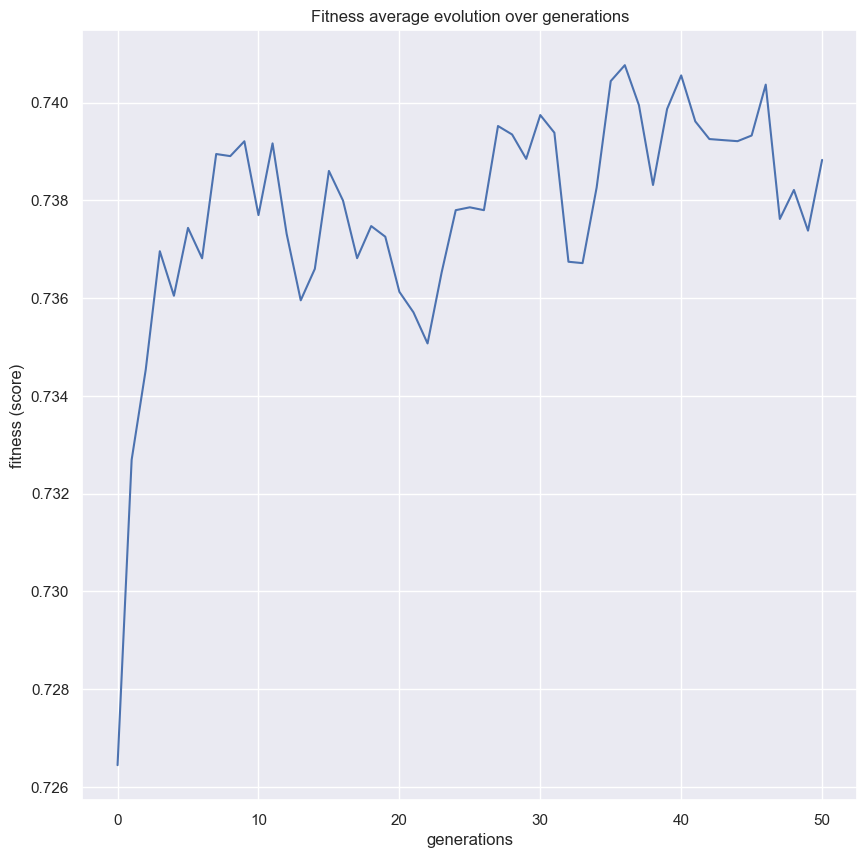

In [98]:
# Define the fitness function for genetic algorithm
def fitness_function(estimator, X, y):
    return cross_val_score(estimator, X, y, cv=cv_strategy, scoring='accuracy').mean()

# Genetic Algorithm for Random Forest
ga_rf = GAFeatureSelectionCV(
    estimator=RandomForestClassifier(),
    cv=cv_strategy,
    scoring='accuracy',
    population_size=50,
    generations=50,
    n_jobs=-1,
    verbose=2
)
ga_rf.fit(X_train, y_train)
best_params_ga_rf = ga_rf.best_features_

# Plot the fitness evolution for Random Forest
plot_fitness_evolution(ga_rf)

In [ ]:
# Optuna for Logistic Regression
def objective_log_reg(trial):
    param = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e2),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear'])
    }
    log_reg = LogisticRegression(**param, random_state=42, max_iter=1000)
    return cross_val_score(log_reg, X_train, y_train, cv=cv_strategy, scoring='accuracy').mean()

study_log_reg = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_log_reg.optimize(objective_log_reg, n_trials=50)
best_params_optuna_log_reg = study_log_reg.best_params

In [ ]:
# Optuna for Support Vector Machine
def objective_svm(trial):
    param = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e2),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e1),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
    }
    svm = SVC(**param, random_state=42)
    return cross_val_score(svm, X_train, y_train, cv=cv_strategy, scoring='accuracy').mean()

study_svm = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_svm.optimize(objective_svm, n_trials=50)
best_params_optuna_svm = study_svm.best_params

In [101]:
# Print the best parameters found by sklearn-genetic-opt and Optuna
print("Best parameters found by Genetic Algorithm for Random Forest:", best_params_ga_rf)
print("Best parameters found by Optuna for Logistic Regression:", best_params_optuna_log_reg)
print("Best parameters found by Optuna for Support Vector Machine:", best_params_optuna_svm)

Best parameters found by Genetic Algorithm for Random Forest: [False  True False  True False False]
Best parameters found by Optuna for Logistic Regression: {'C': 6.7626763183455845, 'solver': 'lbfgs'}
Best parameters found by Optuna for Support Vector Machine: {'C': 13.883133317385248, 'gamma': 0.17991982328035866, 'kernel': 'rbf'}


Ahora entrenamos los modelos con los hiperparametros

In [102]:
# Initialize the classifiers with the best parameters found by sklearn-genetic-opt and Optuna
best_ga_rf = ga_rf.best_estimator_
best_optuna_log_reg = LogisticRegression(**best_params_optuna_log_reg, random_state=42, max_iter=1000)
best_optuna_svm = SVC(**best_params_optuna_svm, random_state=42)

# List of classifiers for validation
best_classifiers_opt = {
    'Random Forest (GA)': best_ga_rf,
    'Logistic Regression (Optuna)': best_optuna_log_reg,
    'Support Vector Machine (Optuna)': best_optuna_svm
}

# Validate each classifier using cross-validation
for name, clf in best_classifiers_opt.items():
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv_strategy, scoring='accuracy')
    print(f'{name} Classifier:')
    print(f'Cross-Validation Accuracy Scores: {cv_scores}')
    print(f'Mean Accuracy: {cv_scores.mean()}')
    print(f'Standard Deviation: {cv_scores.std()}\n')

Random Forest (GA) Classifier:
Cross-Validation Accuracy Scores: [0.70938628 0.73960217 0.73960217 0.73056058 0.73598553]
Mean Accuracy: 0.7310273467336026
Standard Deviation: 0.011315408751631806

Logistic Regression (Optuna) Classifier:
Cross-Validation Accuracy Scores: [0.72743682 0.72694394 0.73417722 0.7323689  0.74321881]
Mean Accuracy: 0.7328291367728373
Standard Deviation: 0.005893843160726922

Support Vector Machine (Optuna) Classifier:
Cross-Validation Accuracy Scores: [0.75451264 0.7323689  0.74141049 0.74321881 0.75768535]
Mean Accuracy: 0.7458392359365718
Standard Deviation: 0.009203138898941267



Podemos observar que los 3 obtienen resultados similares, pero el modelo de Random Forest obtiene un mejor rendimiento en el conjunto de validación.

# Interpretaciones Finales

In [103]:
# Rendimiento de los clasificadores antes de la optimizacion de hiperparametros
print("Rendimiento de los clasificadores antes de la optimizacion de hiperparametros:")
for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    print(f'{name} Classifier:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')

# Rendimiento de los clasificadores despues de la optimizacion de hiperparam
print("Rendimiento de los clasificadores despues de la optimizacion de hiperparam:")
for name, clf in best_classifiers.items():
    clf.fit(X_train, y_train)  # Fit the classifier on the training data
    y_pred = clf.predict(X_test)
    print(f'{name} Classifier:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')

# Rendimiento de los clasificadores despues de la optimizacion de hiperparam
print("Rendimiento de los clasificadores despues de la optimizacion de hiperparam:")
for name, clf in best_classifiers_opt.items():
    clf.fit(X_train, y_train)  # Fit the classifier on the training data
    y_pred = clf.predict(X_test)
    print(f'{name} Classifier:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')

Rendimiento de los clasificadores antes de la optimizacion de hiperparametros:
Random Forest Classifier:
Accuracy: 0.7485549132947977
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        61
           1       0.51      0.41      0.46       150
           2       0.83      0.89      0.86       481

    accuracy                           0.75       692
   macro avg       0.62      0.58      0.60       692
weighted avg       0.73      0.75      0.74       692

Confusion Matrix:
[[ 27  15  19]
 [ 17  62  71]
 [  8  44 429]]

Logistic Regression Classifier:
Accuracy: 0.7153179190751445
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.05      0.09        61
           1       0.42      0.17      0.24       150
           2       0.75      0.97      0.85       481

    accuracy                           0.72       692
   macro avg       0.51      0.40      0.

Podemos observar que el modelo `RandomForest` obtuvo el mayor rendimiento con un `accuracy` de 0.74, seguido por `SVM` con 0.73 y `LogisticRegression` con 0.72. Aunque los resultados son similares, `RandomForest` supera a los otros dos en términos de precisión y recall para las clases minoritarias, lo que indica que es más efectivo en la clasificación de puestos de trabajo con menor frecuencia. Además, `RandomForest` es robusto frente a valores atípicos y puede manejar tanto características numéricas como categóricas, lo que lo convierte en una buena opción para este problema.